<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Creating-a-model" data-toc-modified-id="Creating-a-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Creating a model</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Importance</a></span><ul class="toc-item"><li><span><a href="#Mean-Decrease-Impurity" data-toc-modified-id="Mean-Decrease-Impurity-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Mean Decrease Impurity</a></span></li><li><span><a href="#Permutation-Importance" data-toc-modified-id="Permutation-Importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Permutation Importance</a></span></li></ul></li><li><span><a href="#Feature-Contributions" data-toc-modified-id="Feature-Contributions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Contributions</a></span><ul class="toc-item"><li><span><a href="#Plotting-feature-contributions" data-toc-modified-id="Plotting-feature-contributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plotting feature contributions</a></span><ul class="toc-item"><li><span><a href="#Boxplots" data-toc-modified-id="Boxplots-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Boxplots</a></span></li><li><span><a href="#Swarmplots" data-toc-modified-id="Swarmplots-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Swarmplots</a></span></li><li><span><a href="#Plotting-Feature-Contributions-against-Feature-Values" data-toc-modified-id="Plotting-Feature-Contributions-against-Feature-Values-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Plotting Feature Contributions against Feature Values</a></span></li><li><span><a href="#Heatmaps" data-toc-modified-id="Heatmaps-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Heatmaps</a></span></li></ul></li></ul></li><li><span><a href="#Joint-Feature-Contributions" data-toc-modified-id="Joint-Feature-Contributions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Joint Feature Contributions</a></span></li><li><span><a href="#PDP-and-ICE-plots" data-toc-modified-id="PDP-and-ICE-plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PDP and ICE plots</a></span><ul class="toc-item"><li><span><a href="#Centered-ICE-Plots" data-toc-modified-id="Centered-ICE-Plots-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Centered ICE Plots</a></span></li><li><span><a href="#Two-dimensional-PDPs" data-toc-modified-id="Two-dimensional-PDPs-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Two-dimensional PDPs</a></span></li></ul></li><li><span><a href="#LIME" data-toc-modified-id="LIME-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LIME</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>SHAP</a></span></li><li><span><a href="#Resources" data-toc-modified-id="Resources-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Resources</a></span></li></ul></div>

In this post I explore different tools and methods that can be used to try and interpret "black box" models. 

Since the NFL draft is today, I thought a fun dataset to use for this topic would be the NFL combine data.
Using that data we'll first build a model to predict the early career performance for NFL defensive ends (DE). After that, we will use different interpretability methods to better understand the model.

# Creating a model

Let's get started by importing what we need to set up the data and our modeling pipeline.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

from skll.metrics import spearman

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings

In [3]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,9)})
RANDOM_STATE = 420
N_JOBS=8

Here we load in the data that contains each player's combine information and their 3 year [Approximate Value](https://www.pro-football-reference.com/blog/index37a8.html), which we will use as measure of early career performance (and going forward will be abbreviated as AV).
When building our model we won't be predicting a defensive end's AV, instead we'll be predicting be where his AV ranks (as a percentile) among other defensive ends. Players with high a AV should be closer to 1, while players with low AV should be closer to 0. 

**NOTE:** If you want read up on which combine measurables matter for each NFL position, take a look at [Bill Lotter's](https://twitter.com/bill_lotter?lang=en) [series](http://harvardsportsanalysis.org/2015/02/the-nfl-combine-actually-matters/) of [blog](http://harvardsportsanalysis.org/2015/02/the-combine-actually-matters-part-2/) [posts](http://harvardsportsanalysis.org/2015/02/the-combine-actually-matters-part-3-predicting-the-draft/) on the topic.

In [4]:
# read in our data
data_df = pd.read_csv('data/combine_data_since_2000_PROCESSED_2018-04-26.csv')
# onyl get players that have been in the league for 3 years
data_df2 = data_df.loc[data_df.Year <= 2015].copy()
# calculate the player AV percentiles by position
data_df2['AV_pctile'] = (data_df2.groupby('Pos')
                                  .AV
                                  .rank(pct=True,
                                        method='min', 
                                        ascending=True))

In [5]:
data_df2.columns

Index(['Player', 'Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'BenchReps',
       'BroadJump', 'Cone', 'Shuttle', 'Year', 'Pfr_ID', 'AV', 'Team', 'Round',
       'Pick', 'AV_pctile'],
      dtype='object')

Now that we've loaded the data and calculated the AV percentiles, let's get the DE data and create a training set and testing set. We will train and tune our model on the first 8 years (2000-2011) of combine data and then test it on the next 4 years (2012-2015).

In [6]:
# Get the data for the position we want, in this case it's DE
pos_df = data_df2.loc[data_df2.Pos=='DE'].copy().reset_index(drop=True)

# Split the data into train and test sets
train_df = pos_df.loc[pos_df.Year <= 2011]
test_df = pos_df.loc[pos_df.Year.isin([2012, 2013, 2014, 2015])]

We'll be build a random forest model since that seems to be the [most common](https://www.kaggle.com/surveys/2017) "black box" algorithm people use at work. One thing to to note is that in our modeling `Pipeline` we will need to include an `Imputer` because some DEs are missing data as they did not participate in all the combine drills.

In [7]:
# Combine measurables
features = ['Forty',
            'Wt',
            'Ht',
            'Vertical',
            'BenchReps',
            'BroadJump',
            'Cone',
            'Shuttle']
# what we want to predict
target = 'AV_pctile'

X = train_df[features].values
y = train_df[target].values

# the modeling pipeline
pipe = Pipeline([("imputer", Imputer()),
                 ("estimator", RandomForestRegressor(random_state=RANDOM_STATE))])

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


To tune our model we will use `BayesSearchCV` from `scikit-optimize`, which utilizes bayesian optimization to find the best hyperparameters. We'll use Spearman's rank correlation as our scoring metric since we are mainly concerned with the ranking of players when it comes to the draft.

In [10]:
# We use spearman's rank correlation as the scoring metric since
# we are concerned with ranking the players
spearman_scorer = make_scorer(spearman)

# the hyperparamters to search over, including different imputation strategies
rf_param_space = {
    'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
    'estimator__max_features': Integer(1, 8),
    'estimator__n_estimators': Integer(50, 500), 
    'estimator__min_samples_split': Integer(2, 200),
}
# create our search object
search = BayesSearchCV(pipe, 
                      rf_param_space, 
                      cv=10,
                      n_jobs=N_JOBS, 
                      verbose=0, 
                      error_score=-9999, 
                      scoring=spearman_scorer, 
                      random_state=RANDOM_STATE,
                      return_train_score=True, 
                      n_iter=75)
# fit the model
# I get some funky warnings, possibly due to the spearman scorer,
# I choose to suppress them
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(X, y) 

In [11]:
# best model parameters
search.best_params_

{'estimator__max_features': 6,
 'estimator__min_samples_split': 95,
 'estimator__n_estimators': 50,
 'imputer__strategy': 'median'}

In [10]:
# CV score
search.best_score_

0.3902053071122255

In [11]:
# CV standard deviation
search.cv_results_['std_test_score'][search.best_index_]

0.14517527040832545

Now that we've tuned our model let's evaluate it on the test set.

In [12]:
# test set data
X_test = test_df[features].values
y_test = test_df[target].values
# predictions
y_pred = search.predict(X_test)
# evaluation
model_test_score = spearman_scorer(search, X_test, y_test)
model_test_score

0.22046871361576115

So our model's predictions had a Spearman's rank correlation of about 0.209. Is that good or bad? I'm not sure. To get a better sense of how good or how bad of a score that is we can use the actual draft picks as a comparison point.

In [13]:
# create percentiles for nfl draft picks
# Lower numerical picks (e.g. 1, 2, 3) are ranked closer to 1
# Higher numerical picks (e.g. 180, 200, etc) are ranked closer to 0
draft_pick_pctile = test_df.Pick.rank(pct=True,
                                      method='min', 
                                      ascending=False, 
                                      na_option='top')
spearman(y_test, draft_pick_pctile)

0.6425823905799751

It looks like NFL teams are 3 times better at ranking DEs than our model.

Ok great, now that we have our model let's explore the different tools we can use to better understand it.

# Feature Importance

## Mean Decrease Impurity

When using a tree-ensemble like random forest you can find out which features the model found valuable by checking the feature importances.  In `scikit-learn` the feature importances are a reflection of how well a feature reduces some criterion. In our regression example that criterion is mean squared error.  This method for calculating feature importance is typically called mean decrease impurity or gini importance.

We can access our model's feature importances with the `feature_importances_` attribute.

In [12]:
# get the estimator and imputer from our pipeline, which will be used
# as we try and interpret our model
estimator = search.best_estimator_.named_steps['estimator']
imputer = search.best_estimator_.named_steps['imputer']

estimator.feature_importances_

array([0.38664449, 0.39690086, 0.        , 0.0163551 , 0.02449233,
       0.07793376, 0.06069943, 0.03697402])

Alternatively, we could use `eli5`'s `explain_weights_df` function, which returns the importances and the feature names we pass it as a `pandas` `DataFrame`.

In [13]:
import eli5

# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=features)
feat_imp_df

,feature,weight,std
0,Wt,0.396901,0.184630
1,Forty,0.386644,0.226609
2,BroadJump,0.077934,0.148922
3,Cone,0.060699,0.127488
4,Shuttle,0.036974,0.087779
5,BenchReps,0.024492,0.107758
6,Vertical,0.016355,0.060729
7,Ht,0.000000,0.000000


So it looks like a player's weight and their forty time are important to model.  A thing to note is that `explain_weights_df` also returns the standard deviations, but they may not be trustworthy as those values assume a normal distribution.  Instead of relying on those standard deviations we can access each tree in our ensemble and plot the full distribution of feature importances.

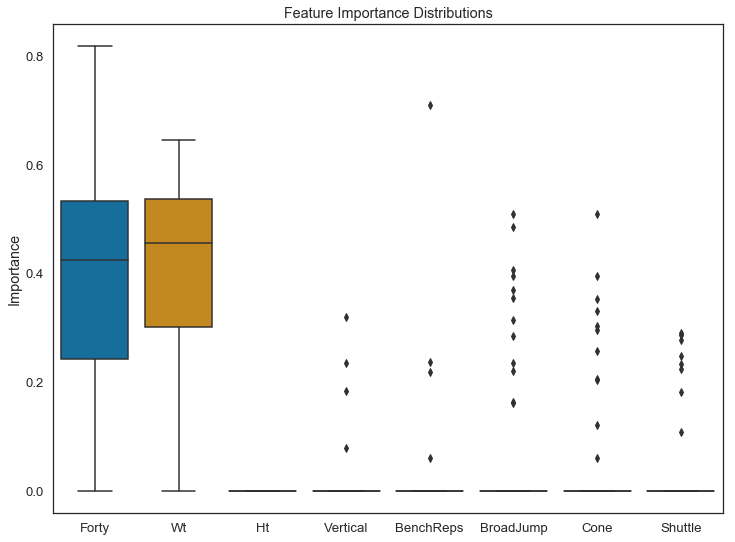

In [14]:
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

## Permutation Importance

Permutation importances or mean decrease accuracy (MDA) is an alternative to mean decrease impurity that can be applied to any model. The basic idea of permutation importance is to permute the values of each feature and measure how much that permutation negatively impacts the scoring metric (which in our case is the Spearman's rank correlation).  This gives us a sense of how our model would perform without that specific feature. All we need to do calculate permutation importance is use `PermutationImportance` from `eli5`.

In [15]:
from eli5.sklearn import PermutationImportance
import eli5

# we need to impute the data first before calculating permutation importance
train_X_imp = imputer.transform(X)
# set up the met-estimator to calculate permutation importance on our training
# data
perm_train = PermutationImportance(estimator, scoring=spearman_scorer,
                                   n_iter=50, random_state=RANDOM_STATE)
# fit and see the permuation importances
perm_train.fit(train_X_imp, y)
eli5.explain_weights_df(perm_train, feature_names=features)

,feature,weight,std
0,Wt,0.296295,0.040088
1,Forty,0.243095,0.036528
2,Cone,0.021561,0.005570
3,BroadJump,0.017505,0.007080
4,Shuttle,0.008984,0.004294
5,Vertical,0.002665,0.002230
6,BenchReps,0.002604,0.002145
7,Ht,0.000000,0.000000


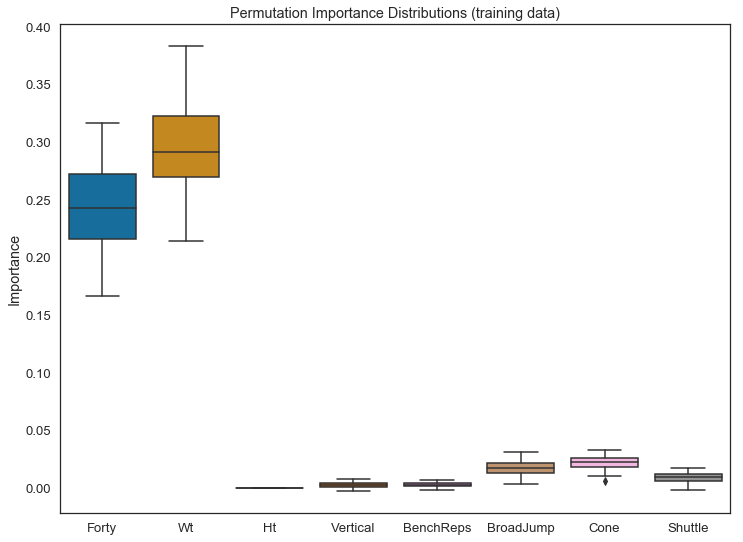

In [16]:
# plot the distributions
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_,
                                      columns=features)
(sns.boxplot(data=perm_train_feat_imp_df)
        .set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'));

Based on the permutation importances it again looks like Forty and Wt are the two most important features to the model.

# Feature Contributions

While feature importances can provide us insight into which variables a model finds valuable, they don't tell us how those features impact our model's predictions. One way to actually do that is by using the decision paths in our trees to see how much each feature changes the predictions when going from the parent to the child node.
In the end we can break down these feature contributions in a linear manner such that our predictions can be interpreted like so: 

$$prediction = bias + feature_{1}contribution + feature_{2}contribution +... feature_{n}contribution$$


Ando Saabas has written a [few](http://blog.datadive.net/interpreting-random-forests/) [blog](http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/) [posts](http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/) that delve into this topic.  For now I will try to explain how feature contributions are calculated by looking at an example that uses a shallow tree in our forest.

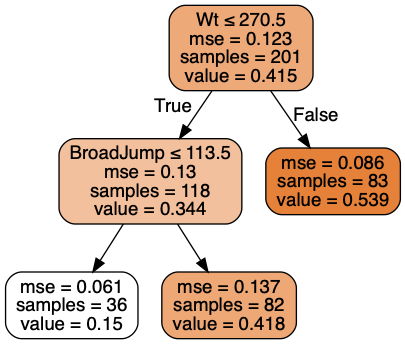

In [18]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from io import StringIO  

# source for plotting decision tree
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
# Get all trees of depth 2 in the random forest
depths2 = [tree for tree in estimator.estimators_ if tree.tree_.max_depth==2]
# grab the first one
tree = depths2[0]
# plot the tree
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=features, 
                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

To keep things simple let's find the feature contributions for a player that follows the leftmost path in the tree above, say a player who weighs 260 lbs and runs 4.6 seconds in the forty yard dash. 

The player first starts at the root (top) node, where the mean AV percentile of all the samples is 0.414 (this is value of our bias term). At the first split, the tree considers whether the player is 270.5 lbs or less, so any change in the prediction caused by this split is attributed to the player's weight.  Our player falls into the left child node because he weighs 260 lbs.  Since the average percentile at this node is 0.317 versus 0.414 in the parent node, we can say that the player's weight caused a decrease of 0.097 percentage points in his predicted AV percentile.  Now for the split at this new node, the tree considers whether the player runs a 4.755 forty or less. The player in our example runs a 4.6 forty, so after this split, he ends up in the leftmost leaf node of the tree. At this leaf node the player's final predicted percentile is 0.481, since that is an increase of 0.164 percentage points from the previous node, we can say that the player's forty time contributed 0.164 percentage points to his predicted AV percentile.
In the end, the feature contributions for this player's predicted AV percentile are as follows:

$$\underset{\text{AV %ile}}{0.481} = \underset{\text{bias}}{0.414}-\underset{\text{Wt}}{0.097}+\underset{\text{Forty}}{0.164}$$

Which are the contribution values we get when we use `eli5`'s `explain_prediction_df` function.

In [17]:
# simple exmaple of a player with a 4.6 Forty and a Wt of 260 lbs
example = np.array([4.6, 260, 0, 0, 0, 0, 0, 0])
eli5.explain_prediction_df(tree, example, feature_names=features)

NameError: name 'tree' is not defined

And 0.481 should be what the tree predicts.

In [ ]:
tree.predict(example.reshape(1,-1))

Which it does. To calculate the bias term and feature contributions for the entire forest of trees, all you do is average the bias terms and feature contributions of all the trees.

**NOTE:** I'm aware of two libraries that allow you to easily calculate these kinds of feature contributions, `eli5` and Ando Sabaas' `treeintepretter`.  Besides for the difference in their APIs there are differences in which algorithms they can be used with. `treeinterpretter` currently works for the following `scikit-learn` estimators:

- DecisionTreeRegressor
- DecisionTreeClassifier
- ExtraTreeRegressor
- ExtraTreeClassifier
- RandomForestRegressor
- RandomForestClassifier
- ExtraTreesRegressor
- ExtraTreesClassifier

`eli5` works for those estimator plus both of `scikit-learn`'s gradient boosting estimators as well as XGBoost and LightGBM estimators.


Now let's actually get the feature contributions for each sample in our training and testing sets.  One thing to note is that the `explain_prediction_df` only calculates the contributions one observation at a time, which can be time consuming. To speed things up I wrote a helper function that let's us use multiple processes (i.e. multiple cpu cores) to get the feature contributions for all our predictions.

In [27]:
from concurrent.futures import ProcessPoolExecutor

def multiproc_iter_func(max_workers, an_iter, func, item_kwarg, **kwargs):
    """
    A helper functions that applies a function to each item in an iterable using
    multiple processes. 'item_kwarg' is the keyword argument for the item in the
    iterable that we pass to the function.
    """
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_results = [executor.submit(func, **{item_kwarg: item}, **kwargs)
                          for item in an_iter]

        results = [future.result() for future in future_results]
        
    return results

In [19]:
train_X_imp.shape

(316, 8)

In [28]:
# Contibrutions for training set predictions
# construct a list of all contributions for the entire train set
train_expl_list = multiproc_iter_func(N_JOBS, train_X_imp, 
                                      eli5.explain_prediction_df, 'doc',
                                      estimator=estimator, 
                                      feature_names=features)
# concatenate them into 1 large dataframe, with the proper player name as an
# index
train_expl_df = pd.concat(train_expl_list, keys=train_df.Player, 
                          names=['Player'])
# take a look at a couple of players
train_expl_df.head(18)

target    feature    weight    value
Player                                                
Michael Boireau 0      y     <BIAS>  0.421975    1.000
                1      y         Wt  0.044442  274.000
                2      y  BenchReps  0.001286   26.000
                3      y       Cone  0.000321    7.680
                4      y   Vertical -0.003913   29.000
                5      y    Shuttle -0.005441    4.490
                6      y  BroadJump -0.013356  105.000
                7      y      Forty -0.069549    5.090
Courtney Brown  0      y     <BIAS>  0.421975    1.000
                1      y      Forty  0.015052    4.780
                2      y    Shuttle  0.004554    4.410
                3      y  BenchReps  0.001179   24.000
                4      y       Cone  0.000954    7.365
                5      y  BroadJump -0.000392  114.000
                6      y   Vertical -0.002890   33.000
                7      y         Wt -0.032680  269.000
Lamont Bryant   0      y     <BIAS>  0.421975    1.000
                1      y    Shuttle  0.001609    4.410

In [30]:
# Contributions for test set predictions
# we need to impute the missing values in the test set
test_X_imp = imputer.transform(X_test)
# now repeat what we did with the training data on the test data
test_expl_list = multiproc_iter_func(N_JOBS, test_X_imp, 
                                     eli5.explain_prediction_df, 'doc', 
                                     estimator=estimator,
                                     feature_names=features)

test_expl_df = pd.concat(test_expl_list, keys=test_df.Player, 
                         names=['Player'])
test_expl_df.head(18)

target    feature    weight    value
Player                                                
Frank Alexander 0      y     <BIAS>  0.421975    1.000
                1      y      Forty  0.022500    4.800
                2      y         Wt  0.018340  270.000
                3      y    Shuttle  0.004554    4.410
                4      y       Cone  0.001737    7.365
                5      y  BenchReps  0.001179   24.000
                6      y   Vertical -0.001238   33.000
                7      y  BroadJump -0.001392  114.000
Jake Bequette   0      y     <BIAS>  0.421975    1.000
                1      y         Wt  0.063303  274.000
                2      y      Forty  0.038799    4.750
                3      y       Cone  0.016279    6.900
                4      y    Shuttle  0.011171    4.070
                5      y   Vertical  0.001702   34.000
                6      y  BenchReps  0.001179   24.000
                7      y  BroadJump -0.002858  113.000
Jamie Blatnick  0      y     <BIAS>  0.421975    1.000
                1      y    Shuttle  0.018533    4.200

In [31]:
# Double check that the sums of contributions equal the actual predictions
y_pred_sums = test_expl_df.groupby('Player').weight.sum()
np.allclose(y_pred, y_pred_sums)

True

## Plotting feature contributions
Now that we have all these feature contributions let's make some plots to better understand them.

### Boxplots
First let's make a boxplot to see the contribution distributions of each feature.

In [32]:
# I"m creating one big dataframe that includes both train and test
# to plot them on same plot using seaborn's boxplot
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
test_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
train_expl_df['data'] = 'train'
test_expl_df['data'] = 'test'
train_test_expl_df = pd.concat([train_expl_df, test_expl_df])
sns.boxplot(x='feature', y='contribution', hue='data', order=features,
            data=train_test_expl_df.loc[train_test_expl_df.feature!='<BIAS>'],
            palette={'train': 'salmon', 
                     'test':'deepskyblue'})
plt.legend(loc=9)
plt.title('Distributions of Feature Contributions');

### Swarmplots
We can also use swarmplots which allow for a more granular view of the distribution since they plot each individual observation. If we color each point by the associated feature's (scaled) value, we can view how the change in a feature's value changes along with its contribution.

`seaborn` doesn't support a colorbar by default so it's something we have to add on our own.  I hacked together function (based on [this](https://stackoverflow.com/questions/40814612/map-data-points-to-colormap-with-seaborn-swarmplot) stackoverflow answer) that will let us add a vertical colorbar to the right of our swarmplots.

In [33]:
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [34]:
# a hacky function that plots a swarmplot along with a colorbar
# based off the code found here:
# https://stackoverflow.com/questions/40814612/map-data-points-to-colormap-with-seaborn-swarmplot
def swarmplot_with_cbar(cmap, cbar_label, *args, **kwargs):
    fig = plt.gcf()
    ax = sns.swarmplot(*args, **kwargs)
    # remove the legend, because we want to set a colorbar instead
    ax.legend().remove()
    ## create colorbar ##
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="3%", pad=0.05)
    fig.add_axes(ax_cb)
    cb = ColorbarBase(ax_cb, cmap=cmap, orientation='vertical')
    cb.set_label(cbar_label, labelpad=10)
    
    return fig

In [22]:
# min-max scaling of the feature values allows us to use a colorbar
# to indicate high or low feature values
train_scaled_feat_vals = (train_expl_df.groupby('feature')
                                       .value
                                       .transform(lambda x: x/x.max()))

train_expl_df['scaled_feat_vals'] = train_scaled_feat_vals

cmap = plt.get_cmap('viridis')
cbar_label = 'Feature Value %ile'

plt.title('Distribution of Feature Contributions (training data)')
swarmplot_with_cbar(cmap, cbar_label,  x='feature', y='contribution',
                    hue='scaled_feat_vals', palette='viridis', order=features,
                    data=train_expl_df.loc[train_expl_df.feature!='<BIAS>']);

NameError: name 'train_expl_df' is not defined

In [21]:
test_scaled_feat_vals = (test_expl_df.groupby('feature')
                                      .value
                                      .transform(lambda x: x/x.max()))

test_expl_df['scaled_feat_vals'] = test_scaled_feat_vals

# plt.title('Distribution of Feature Contributions (test data)')
# swarmplot_with_cbar(cmap, cbar_label,  x='feature', y='contribution',
#                     hue='scaled_feat_vals', palette='viridis', order=features,
#                     data=test_expl_df.loc[test_expl_df.feature!='<BIAS>']);

NameError: name 'test_expl_df' is not defined

Based on both plots, we can see that faster forty times and higher weights result in more positive contributions.  The other features tend to have most of their contributions hover around 0.  It's also interest to note the gaps in middle of the Wt distributions on both plots.

### Plotting Feature Contributions against Feature Values

Let's plot the feature contributions against the feature values to get a better sense of how they relate to one another.  We can use `seaborn`'s `lmplot` to easily create a grid of these kinds of plots for both our training and testing data.

In [24]:
test_expl_df.feature

NameError: name 'test_expl_df' is not defined

In [23]:
# fg = sns.lmplot(x='value', y='contribution', col='feature',
#                 data=train_expl_df.loc[train_expl_df.feature!='<BIAS>'], 
#                 col_order=features, sharex=False, col_wrap=3, fit_reg=False,
#                 size=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})
# fg.fig.suptitle('Feature Contributions vs Feature Values (training data)')
# fg.fig.subplots_adjust(top=0.90);

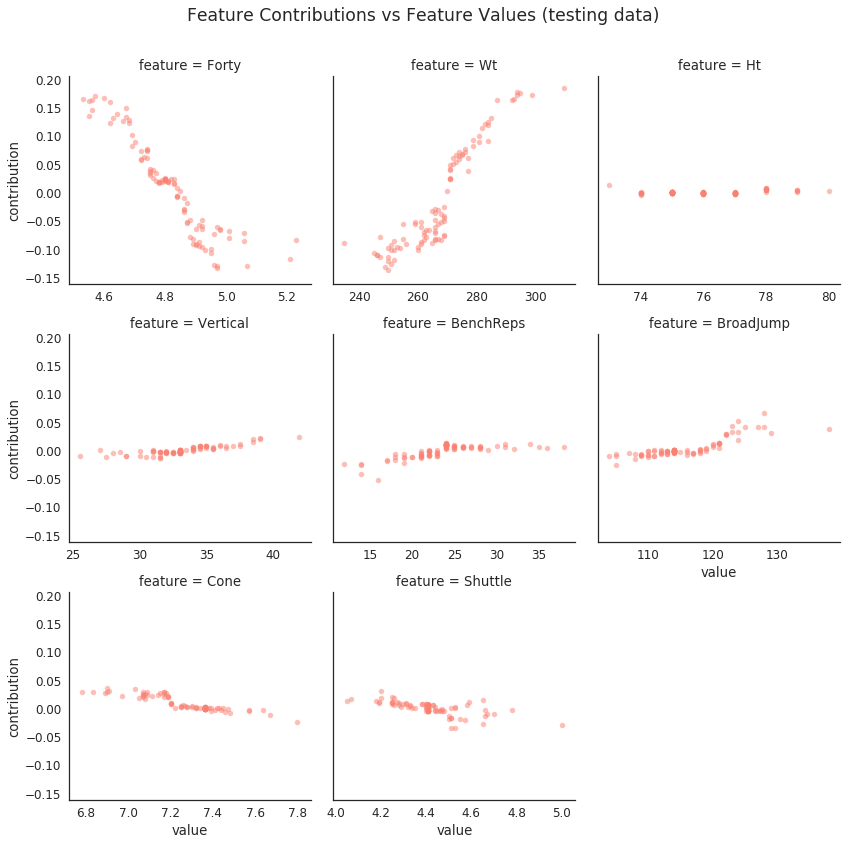

In [30]:
fg = sns.lmplot(x='value', y='contribution', col='feature',
                data=test_expl_df.loc[test_expl_df.feature!='<BIAS>'], 
                col_order=features, sharex=False, col_wrap=3, fit_reg=False, 
                size=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})
fg.fig.suptitle('Feature Contributions vs Feature Values (testing data)')
fg.fig.subplots_adjust(top=0.90);

In both plots for Wt it's interesting to see the rapid increase in contribution at around 270 lbs.  The model essentially believes that weighing more than 270 is automatically a positive factor for a player, while weighing less than that is a negative one.

One thing to note about these plots is that when we see different contributions (e.g. -0.05, -0.10, -0.15) for the same feature value (e.g. a forty time of 5 seconds) there is probably another feature (or set of features) that is causing these differences. To view such feature interactions we can set the color of the dots to reflect the value of another feature.  Let's take a look at how a player's weight interacts with the contribution of their forty time (at least in the training set).

In [50]:
# train_expl_df.groupby(['Player','feature']).contribution.aggregate('first').unstack()

In [53]:
# before we actually plot anything we need to do a bit of data manipulation
# let's pivot the data and create a new dataframe where the columns are
# the feature contributions and each row is a player, with the player
# name as the index value
# here are different ways to pivot column values to columns
# https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns
# based on running %%timeit, the groupby method was fastest 
train_contrib_df = (train_expl_df.groupby(['Player','feature'])
                                 .contribution
                                 .aggregate('first')
                                 .unstack())
# add in the feature values
train_feat_contrib_df = train_contrib_df.merge(train_df[['Player'] + features],
                                               how='left', left_index=True, 
                                               right_on='Player',
                                               suffixes=('_contrib', '_value'))
# now we can plot

In [55]:
# train_feat_contrib_df

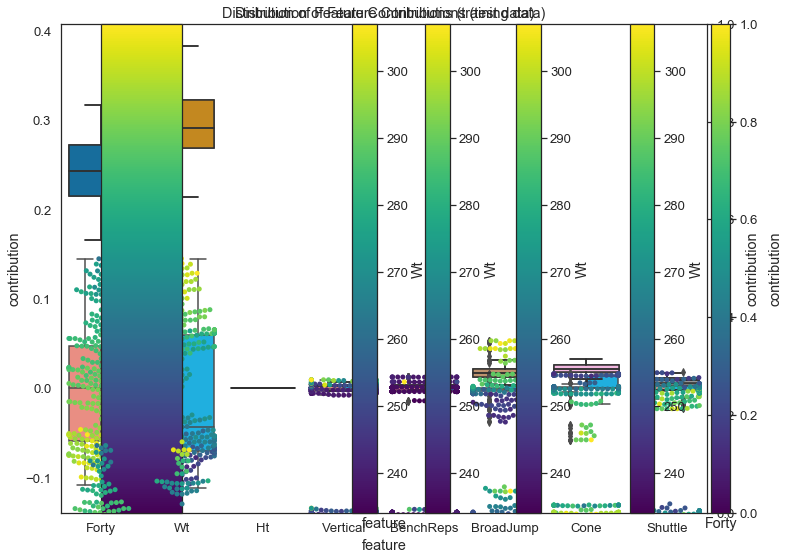

In [58]:
plt.scatter(x='Forty_value', y='Forty_contrib', c='Wt_value', cmap=cmap,
            data=train_feat_contrib_df)
plt.xlabel('Forty')
plt.ylabel('contribution')
plt.colorbar(label='Wt');
plt.show()

We can see that there is some interaction between weight and forty time. Given a specific forty time, players with higher weights tend to have a more positive (or less negative) contribution.

### Heatmaps
With a little data wrangling and `seaborn`'s `heatmap` function we can take a look at the full set of contributions for each player in our test set.

In [61]:
def double_heatmap(data1, data2, cbar_label1, cbar_label2,
                   title='', subplot_top=0.86, cmap1='viridis', cmap2='magma', 
                   center1=0.5, center2=0, grid_height_ratios=[1,4],
                   figsize=(14,10)):
    # do the actual plotting
    # here we plot 2 seperate heatmaps one for the predictions and actual percentiles
    # the other for the contributions
    # the reason I chose to do this is because of the difference in magnitudes
    # between the percentiles and the contributions
    fig, (ax,ax2) = plt.subplots(nrows=2, figsize=figsize, 
                                 gridspec_kw={'height_ratios':grid_height_ratios})

    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.02, top=subplot_top)

    # heatmap for actual and predicted percentiles
    sns.heatmap(data1, cmap="viridis", ax=ax, xticklabels=False, center=center1,
                cbar_kws={'location':'top', 
                          'use_gridspec':False, 
                          'pad':0.1,
                          'label': cbar_label1})
    ax.set_xlabel('')

    # heatmap of the feature contributions
    sns.heatmap(data2, ax=ax2, xticklabels=False, center=center2, cmap=cmap2,
                cbar_kws={'location':'bottom', 
                          'use_gridspec':False, 
                          'pad':0.07, 
                          'shrink':0.41,
                          'label': cbar_label2})
    ax2.set_ylabel('');
    return fig

In [62]:
# get the prediction and actual target values to plot
y_test_and_pred_df = pd.DataFrame(np.column_stack((y_test, y_pred)),
                                  index=test_df.Player,
                                  columns=['true_AV_pctile', 'pred_AV_pctile'])

# let's pivot the data such that the feature contributions are the columns
test_heatmap_df = (test_expl_df.groupby(['Player','feature'])
                               .contribution
                               .aggregate('first')
                               .unstack())

# there may be some NaNs if a feature did not contribute to a prediction, 
# so fill them in with 0s
test_heatmap_df = test_heatmap_df.fillna(0)

# merge our predictions with the the contributions
test_heatmap_df = test_heatmap_df.merge(y_test_and_pred_df, how='left',
                                        right_index=True, left_index=True)
# sort by predictions
test_heatmap_df.sort_values('pred_AV_pctile', ascending=True, inplace=True)

In [63]:
title = 'Feature contributions to predicted AV %ile \nfor each player in the testing data'
fig = double_heatmap(test_heatmap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
                     test_heatmap_df[features].T, '%ile', 'contribution',
                     title=title)

KeyError: "['Ht'] not in index"

The plot above consist of two heatmaps. Each column in both heatmaps represents a player. The rows in the top heatmap represent the true and predicted AV percentiles while the rows in the bottom heatmap represent the the feature contributions for each player prediction.

I like the above visualization because it makes it easy to view a large set of predictions and contributions all at once. I definitely prefer it over the alternative of viewing each set of contributions through a printout out of the `DataFrame`.

# Joint Feature Contributions

A benefit of using a tree-ensemble like our random forest model, is that it captures interactions among our features without us explicitly defining them.  However in our attempt to interpret our model we have only looked at the importances and contributions of individual features.  Since we've yet to measure the impact of the feature interactions that the model has found, we have an incomplete picture of what our model is actually doing.  To gain some insight into these feature interactions we can use the `treeinterpeter` package. It uses the same method as before to calculate contributions, but instead of crediting individual features along the decision paths, `treeinterpeter` allows us to credit the feature interactions.

**NOTE:** If you use XGBoost you can use the [xgbfir](https://github.com/limexp/xgbfir) package to inspect feature interactions. 

Let's use `treeinterpreter` on our simple decision tree from before, in order to get an idea of of how joint feature contributions (i.e. the contributions of the feature interactions) are calculated.

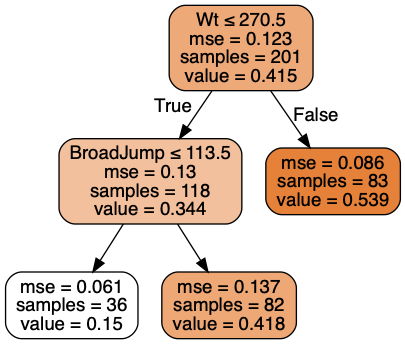

In [64]:
# a reminder of what the tree looks like
Image(graph.create_png())

To get the joint feature contributions, we pass in our estimator and the data to the `predict` function and set `joint_contribution` to `True`.  That should return the prediction, the bias term and the joint feature contributions for our player.

In [68]:
example.reshape(1, -1)

array([[  4.6, 260. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ]])

In [69]:
import treeinterpreter.treeinterpreter as ti
example_pred, example_bias, example_contrib = ti.predict(tree,
                                                         example.reshape(1, -1),
                                                         joint_contribution=True)

In [71]:
# same prediction as before
example_pred

array([[0.14977935]])

In [72]:
# same bias value as before
example_bias

array([0.41520984])

In [73]:
example_contrib

[{(1,): array([-0.07083946]), (1, 5): array([-0.19459103])}]

The joint contributions are returned as list of dictionaries (in our example one dictionary for our one player), where the keys are numeric tuples representing the features (0 represents Forty and 1 represent Wt) and the values are the joint feature contributions. The joint feature contributions for our simple example are as follows:

$$\underset{\text{AV %ile}}{0.481} = \underset{\text{bias}}{0.414}-\underset{\text{Wt}}{0.097}+\underset{\text{Forty & Wt}}{0.164}$$

The contributions are the same values as before, the difference we see here is that instead of crediting the contribution of 0.164 percentage points to just the player's forty time, we also credit the previous feature, Wt, in the decision path. Remember, we are now crediting feature interactions, not just individual features. We only credit a single feature when it's either at the root node (like Wt is) or if it's the only feature used along a decision path.


Let's get the joint feature contributions for the test set predictions.

#### START HERE 

In [88]:
joint_pred, joint_bias, joint_contrib = ti.predict(estimator,
                                                   test_X_imp,
                                                   joint_contribution=True)

In [86]:
joint_contrib[0]

{(0, 1): array([0.0068637]),
 (0, 1, 5): array([0.00110038]),
 (1,): array([0.00317774]),
 (1, 5): array([0.00550042]),
 (1, 6): array([0.0052474]),
 (6,): array([-0.00112752]),
 (0,): array([0.01249659]),
 (0, 6): array([0.00364297]),
 (6, 7): array([-0.00037542]),
 (1, 6, 7): array([-0.00208966]),
 (0, 1, 6): array([0.00293304]),
 (0, 1, 4, 6): array([0.00067037]),
 (0, 1, 4): array([0.00022482]),
 (5, 6): array([-0.00050762]),
 (0, 5, 6): array([-0.0004649]),
 (0, 1, 5, 6): array([0.00328879]),
 (0, 5): array([-0.00087225]),
 (1, 4, 5, 7): array([0.00066135]),
 (0, 1, 4, 5, 7): array([0.00091139]),
 (1, 5, 7): array([0.0009785]),
 (0, 7): array([-0.0010604]),
 (5,): array([-0.00011727]),
 (0, 1, 7): array([0.00317499]),
 (1, 7): array([0.00100621]),
 (0, 1, 3): array([-0.00124581]),
 (1, 4): array([-0.00053728]),
 (0, 1, 3, 4): array([0.00140013]),
 (4,): array([0.00128606]),
 (1, 3, 4): array([0.00082472]),
 (0, 3): array([-0.0008167]),
 (0, 1, 3, 7): array([-0.00091866]),
 (0, 3, 

In [89]:
# double check predictions are correct
np.allclose(y_pred, joint_pred)

False

In [90]:
# the bias is still the same
joint_bias[:3]

array([0.42197493, 0.42197493, 0.42197493])

In [91]:
# 96 observations in test set
len(joint_contrib)

96

In [44]:
# tuples representing the column indexes of our features
list(joint_contrib[0].keys())[:3]

[(0, 1), (0, 1, 2, 5), (0, 1, 5)]

In [45]:
# an example of a joint feature contribution
joint_contrib[0][(0, 1)]

0.01733594064297664

To get the joint feature contributions into more useable format let's match the tuples of indexes to the proper feature names. Then we can construct a `DataFrame` of each player's joint feature contributions, ordered by the absolute value of the contributions.

In [102]:
def create_ordered_joint_contrib_df(contrib):
    df = pd.DataFrame(contrib, columns=['feat_interaction', 'contribution'])
    # order by contribution size 
    new_idx = (df.contribution.abs()
                              .sort_values(inplace=False, ascending=False)
                              .index)
    df = df.reindex(new_idx).reset_index(drop=True)
    return df

In [92]:


# add the names of the feats to the joint contributions
joint_contrib_w_feat_names = []
# for each observation in the join contributions
for obs in joint_contrib:
    # create a list
    obs_contrib = []
    # for each tuple of column indexes
    for k in obs.keys():
        # get the associated feature names
        feature_combo = [features[i] for i in k]
        # get the contribution value
        contrib = obs[k]
        # store that information in the observation individual list
        obs_contrib.append([feature_combo, contrib])
    # append that individual to the large list containing each observations
    # joint feature contributions
    joint_contrib_w_feat_names.append(obs_contrib)

# create an ordered dataframe for each player

In [100]:
# joint_contrib_w_feat_names[0]

In [103]:
joint_contrib_dfs = [create_ordered_joint_contrib_df(contrib)
                     for contrib in joint_contrib_w_feat_names]

In [109]:
len(joint_contrib_dfs)

96

In [111]:
joint_contrib_dfs[0][:3]

,feat_interaction,contribution
0,[Forty],[0.012496593657527328]
1,"[Forty, Wt]",[0.006863696722308165]
2,"[Wt, BroadJump]",[0.005500424579291534]


In [119]:
# now combine them all
joint_contrib_df = pd.concat(joint_contrib_dfs, keys=test_df.Player, names=['Player'])

In [120]:
# joint_contrib_df

In [121]:

joint_contrib_df['feat_interaction'] = joint_contrib_df.feat_interaction.apply(' | '.join) 

In [132]:
joint_contrib_df['contribution'] = joint_contrib_df.contribution.apply(lambda x: x[0]) 

In [133]:
joint_contrib_df.head()

feat_interaction  contribution
Player                                          
Frank Alexander 0            Forty      0.012497
                1       Forty | Wt      0.006864
                2   Wt | BroadJump      0.005500
                3        Wt | Cone      0.005247
                4     Forty | Cone      0.003643

Great, now we have the joint feature contributions for each player in our test set in a nice `DataFrame`.  Let's take a look at how important each feature and feature interaction is to our predictions. To do that we will measure (as a percentage) how much of the total joint contributions an individual feature or feature interaction is responsible for. In other words we are going to measure the relative importance of each feature and feature interaction.

In [134]:
# first get the sum of the absolute values for each joint feature contribution
abs_imp_joint_contrib = (joint_contrib_df.groupby('feat_interaction')
                                          .contribution
                                          .apply(lambda x: x.abs().sum())
                                           .sort_values(ascending=False))

In [135]:
abs_imp_joint_contrib

feat_interaction
Wt                                              3.741071
Forty | Wt                                      2.821232
Forty                                           2.196987
Wt | BroadJump                                  0.487646
Forty | Wt | Cone                               0.481284
Forty | Cone                                    0.472737
Cone                                            0.463951
Wt | Cone                                       0.400599
Forty | Wt | BroadJump                          0.396696
BenchReps                                       0.248039
Forty | Shuttle                                 0.230234
Forty | Wt | Shuttle                            0.225160
Forty | Wt | BroadJump | Cone                   0.206964
BroadJump                                       0.153944
BroadJump | Cone                                0.149692
Wt | Cone | Shuttle                             0.147752
Wt | Vertical                                   0.133671
Forty | Wt | V

In [136]:
rel_imp_join_contrib = abs_imp_joint_contrib / abs_imp_joint_contrib.sum()

In [137]:
rel_imp_join_contrib

feat_interaction
Wt                                              0.260161
Forty | Wt                                      0.196194
Forty                                           0.152783
Wt | BroadJump                                  0.033912
Forty | Wt | Cone                               0.033469
Forty | Cone                                    0.032875
Cone                                            0.032264
Wt | Cone                                       0.027858
Forty | Wt | BroadJump                          0.027587
BenchReps                                       0.017249
Forty | Shuttle                                 0.016011
Forty | Wt | Shuttle                            0.015658
Forty | Wt | BroadJump | Cone                   0.014393
BroadJump                                       0.010706
BroadJump | Cone                                0.010410
Wt | Cone | Shuttle                             0.010275
Wt | Vertical                                   0.009296
Forty | Wt | V

In [138]:
rel_imp_join_contrib.head(15)[::-1]

feat_interaction
BroadJump | Cone                 0.010410
BroadJump                        0.010706
Forty | Wt | BroadJump | Cone    0.014393
Forty | Wt | Shuttle             0.015658
Forty | Shuttle                  0.016011
BenchReps                        0.017249
Forty | Wt | BroadJump           0.027587
Wt | Cone                        0.027858
Cone                             0.032264
Forty | Cone                     0.032875
Forty | Wt | Cone                0.033469
Wt | BroadJump                   0.033912
Forty                            0.152783
Forty | Wt                       0.196194
Wt                               0.260161
Name: contribution, dtype: float64

In [140]:
# then calculate the % of total contribution by dividing by the sum of all absolute vals


rel_imp_join_contrib.head(15)[::-1].plot(kind='barh', color='salmon', 
                                              title='Joint Feature Importances');
plt.ylabel('Features')
plt.xlabel('% of total joint contributions');

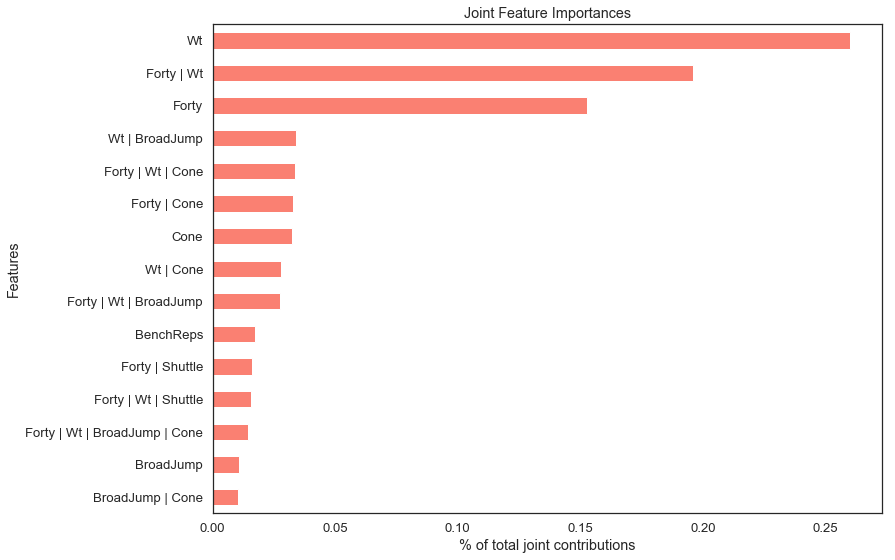

In [141]:
plt.show()

It looks like the interaction between a Forty and Wt was the most important feature interaction in our predictions, accounting for over 20% of the joint feature contributions. Overall Forty, Wt and their interaction account for more than 50% of the total feature contributions.

We can also take a look at the distributions of contributions for each feature and feature interaction.

In [142]:
top_feat_interactions = rel_imp_join_contrib.head(15).index

In [143]:
top_feat_interactions

Index(['Wt', 'Forty | Wt', 'Forty', 'Wt | BroadJump', 'Forty | Wt | Cone',
       'Forty | Cone', 'Cone', 'Wt | Cone', 'Forty | Wt | BroadJump',
       'BenchReps', 'Forty | Shuttle', 'Forty | Wt | Shuttle',
       'Forty | Wt | BroadJump | Cone', 'BroadJump', 'BroadJump | Cone'],
      dtype='object', name='feat_interaction')

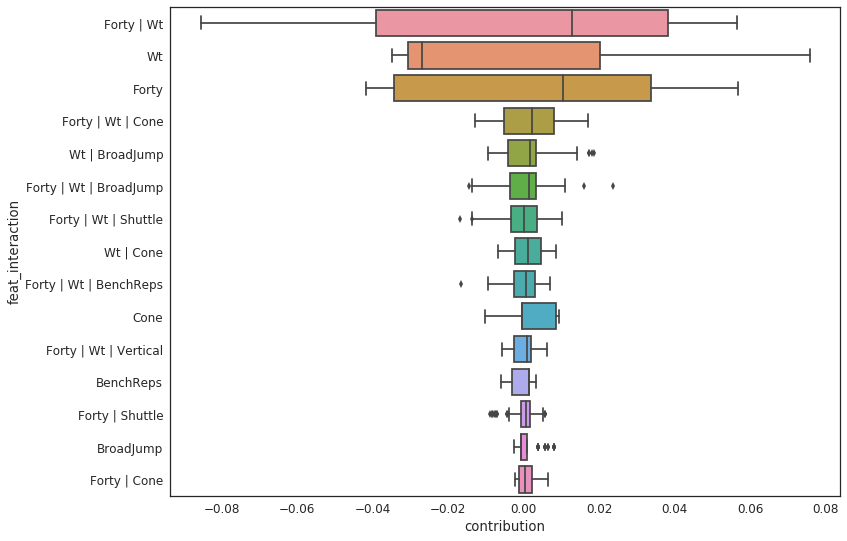

In [49]:

top_contrib_mask = joint_contrib_df.feat_interaction.isin(top_feat_interactions)
sns.boxplot(y='feat_interaction', x='contribution', 
            data=joint_contrib_df.loc[top_contrib_mask],
            orient='h', order=top_feat_interactions);

And finally let's make another double heatmap plot to observe some of the joint contributions for each prediction in our test set.

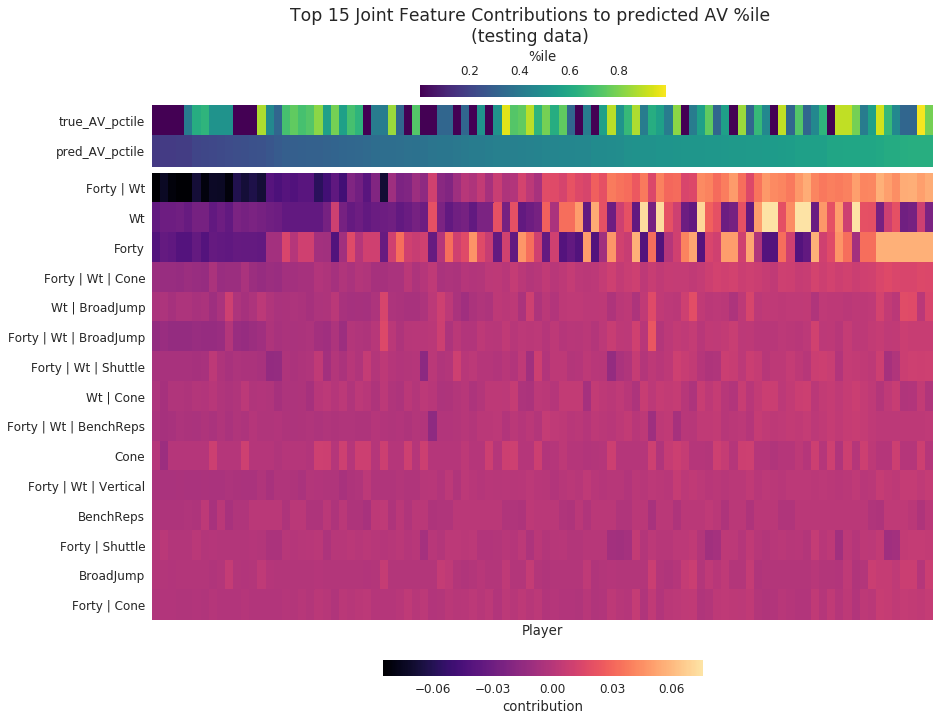

In [50]:
joint_contrib_heatmap_df = (joint_contrib_df[top_contrib_mask]
                               .groupby(['Player','feat_interaction'])
                               .contribution
                               .aggregate('first')
                               .unstack())
joint_contrib_heatmap_df = joint_contrib_heatmap_df.fillna(0)

joint_contrib_heatmap_df = joint_contrib_heatmap_df.merge(y_test_and_pred_df, 
                                                          how='left',
                                                          right_index=True, 
                                                          left_index=True)
# sort by predictions
joint_contrib_heatmap_df.sort_values('pred_AV_pctile', ascending=True, 
                                     inplace=True)

title = 'Top 15 Joint Feature Contributions to predicted AV %ile\n(testing data)'
fig = double_heatmap(joint_contrib_heatmap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
                     joint_contrib_heatmap_df[top_feat_interactions].T, 
                     cbar_label1='%ile', cbar_label2='contribution', 
                     title=title, grid_height_ratios=[1, 7], figsize=(14, 12),
                     subplot_top=0.89)

# PDP and ICE plots

Individual Conditional Expectation (ICE) plots allow us to visualize how changes for a given feature impact the predictions for a set of observations.

Let's use `pycebox` to create an ICE plot to view how changes in the forty yards dash impact our prediction in our training data.

In [51]:
from pycebox.ice import ice, ice_plot

# pcyebox likes the data to be in a DataFrame so let's create one with our imputed data
# we first need to impute the missing data
train_X_imp_df = pd.DataFrame(train_X_imp, columns=features)

We get the ICE values for our feature of interest (Forty) using the `ice` function.

In [52]:
forty_ice_df = ice(data=train_X_imp_df, column='Forty', 
                   predict=search.predict)

And then we create the ICE plot with the `ice_plot` function.

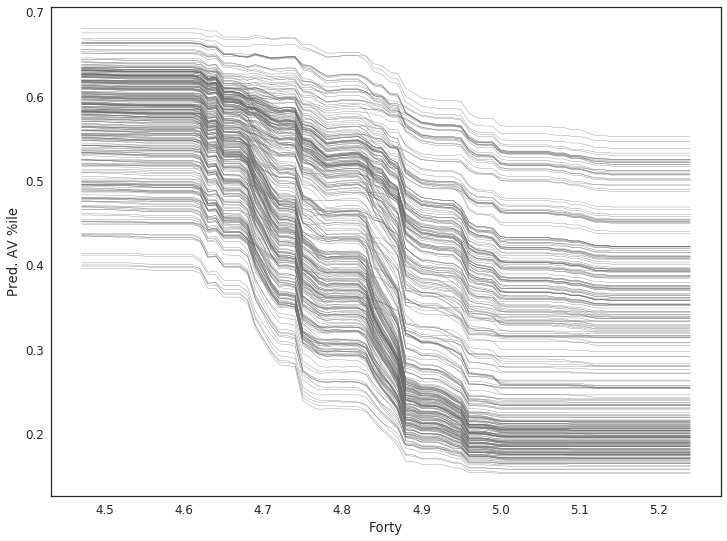

In [53]:
ice_plot(forty_ice_df, c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty');

So how was the above plot created and what is it telling us? To create an ICE plot, we first pick a feature of interest. Then for each observation we make predictions across a range of values for that feature, while holding all other features constant. Finally we just visualize those predictions as curves on a plot. By plotting these curves we are able to observe the relationship between the feature of interest and the predicted target variable. 

In our ICE plot above we can see how each player's predicted AV percentile tends to decrease in a non-linear manner between forty times of 4.6 seconds and 5.0 seconds.  We can also see that each player's prediction is impacted in a different manner.  For example, it looks like the player predictions at the top of the plot do not decrease as much as those at the bottom. The differences we see among the curves indicate that there are interactions between the forty times and the other features. 

To inspect feature interactions we can color the ICE curves by another feature.  We can do that by passing in a feature to `ice_plot`'s `color_by` parameter. Let's color each line by the player's weight.

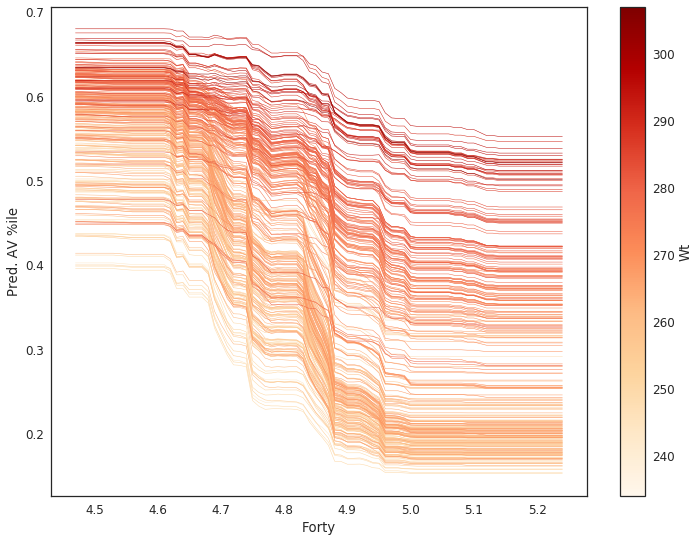

In [54]:
# new colormap for ICE plot
cmap2 = plt.get_cmap('OrRd')
# set color_by to Wt, in order to color each curve by that player's weight
ice_plot(forty_ice_df, linewidth=0.5, color_by='Wt', cmap=cmap2)
# ice_plot doesn't return a colorbar so we have to add one
# hack to add in colorbar taken from here:
# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629
wt_vals = forty_ice_df.columns.get_level_values('Wt').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
# need to create fake array for the scalar mappable or else we get an error
sm._A = []
plt.colorbar(sm, label='Wt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty');

From the plot above we can see that heavier players are not impacted in the same manner as lighter ones.

We can also add the PDP by setting the `plot_pdp` to `True` in the `ice_plot` function. To adjust the styling of the PDP line we pass a dictionary of settings to `pdp_kwargs`.

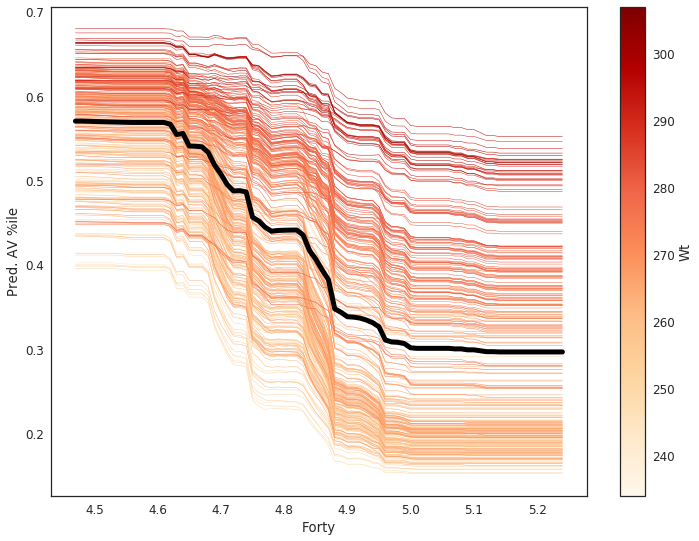

In [55]:
ice_plot(forty_ice_df, linewidth=.5, color_by='Wt', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='Wt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty');

The PDP is the average of all ICE curves on the plot, so the PDP above represents the average change in the predicted AV percentile over the range of forty times.

## Centered ICE Plots

One drawback with our previous ICE plots is that the stacked nature of the lines can make it difficult to observe the differences between the ICE curves. To make it easier to spot those differences we can center or "pinch" the curves at a specific feature value. Typically the minimum is a good centering point. With these centered ICE plots we observe the relative change of the predictions with respect to the predictions at the centered value.

To center our ICE curves at the minimum Forty value we just set `centered` to `True`.

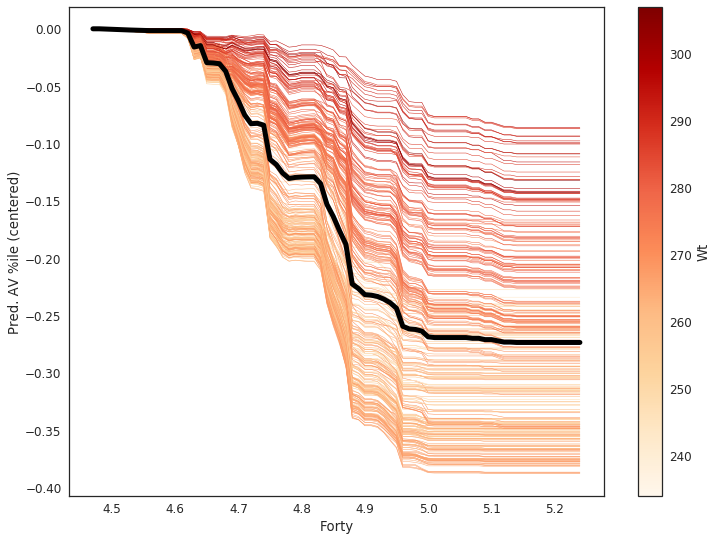

In [56]:
ice_plot(forty_ice_df, linewidth=.5, color_by='Wt', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5}, centered=True)
plt.colorbar(sm, label='Wt')
plt.ylabel('Pred. AV %ile (centered)')
plt.xlabel('Forty');

Note that each line above starts at 0. The y-axis now represents the difference in each player's prediction relative to their prediction at the minimum forty yard dash time  of 4.47 seconds.

Let's take a look at the ICE plots for all our features. To make that easier to do, I created a helper function that can plot out all the ICE plots for each feature. It also adds a rug plot at the bottom of each ICE plot to display information about the distribution of the data.

In [57]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=3, 
                  ncols=3, figsize=(12, 12), sharex=False, sharey=True, 
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the 
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.distplot(data_df[f], ax=ax, hist=False, kde=False, 
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()
        
    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

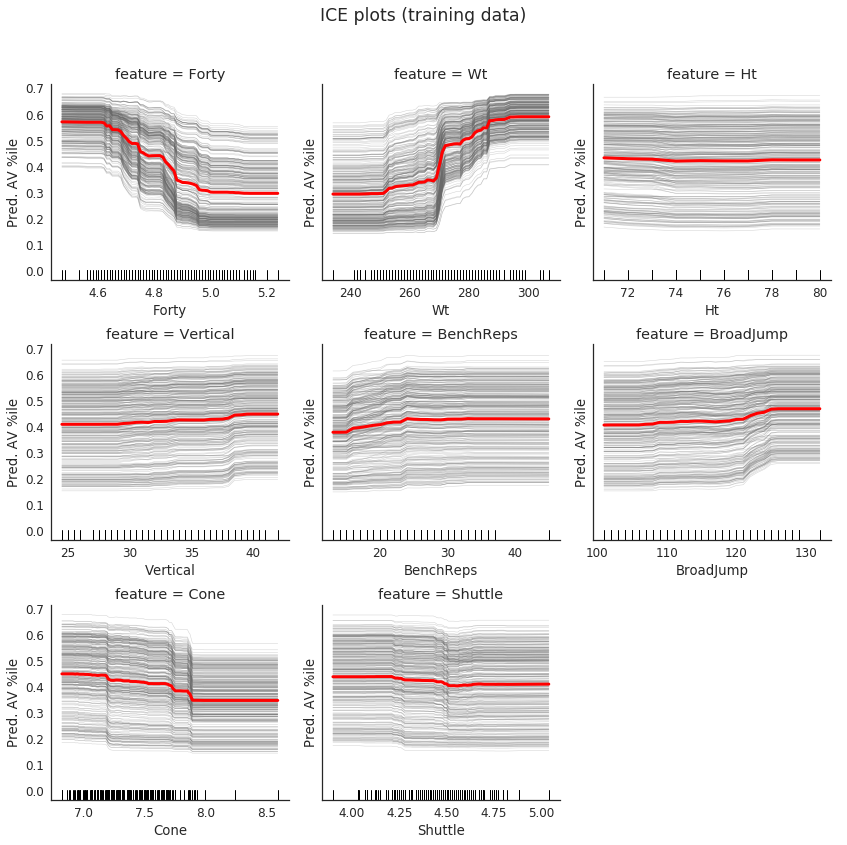

In [58]:
# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=train_X_imp_df, column=feat, predict=estimator.predict) 
                 for feat in features}

fig = plot_ice_grid(train_ice_dfs, train_X_imp_df, features,
                    ax_ylabel='Pred. AV %ile', alpha=0.3, plot_pdp=True,
                    pdp_kwargs={'c': 'red', 'linewidth': 3},
                    linewidth=0.5, c='dimgray')
fig.tight_layout()
fig.suptitle('ICE plots (training data)')
fig.subplots_adjust(top=0.89);

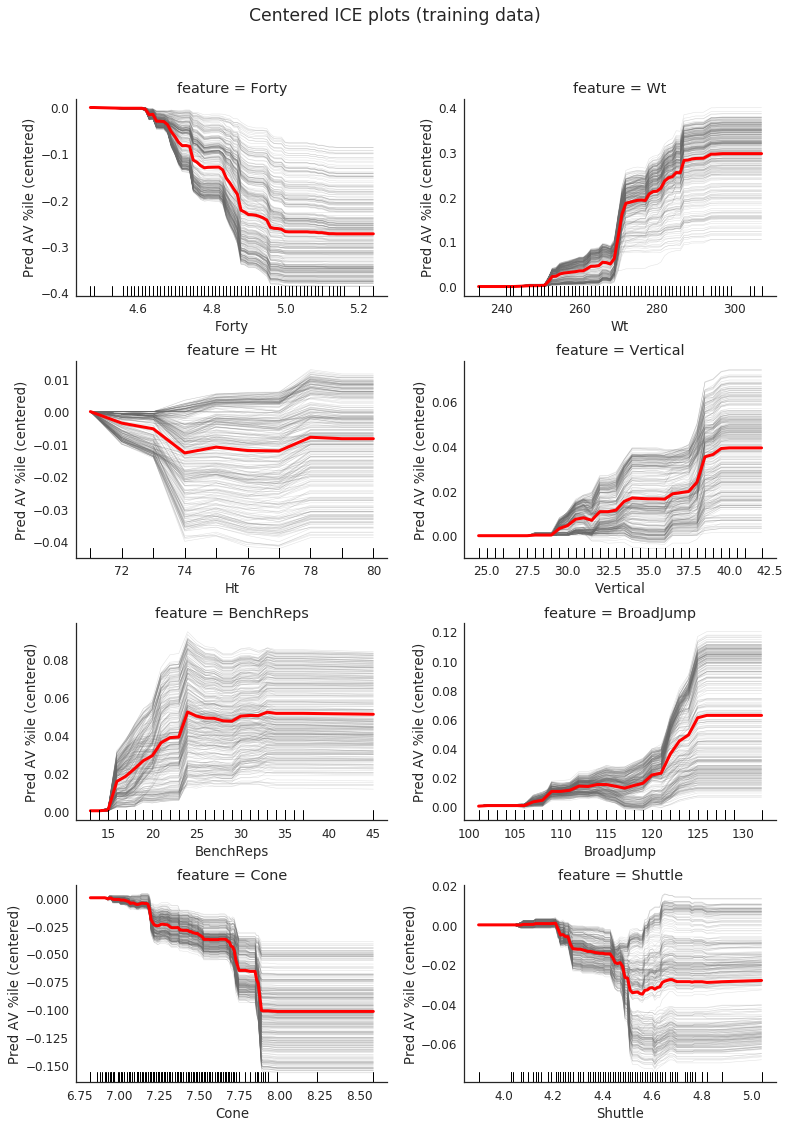

In [59]:
fig = plot_ice_grid(train_ice_dfs, train_X_imp_df, features, 
                    ax_ylabel='Pred AV %ile (centered)',
                    alpha=.2, plot_points=False, plot_pdp=True,
                    pdp_kwargs={"c": "red", "linewidth": 3},
                    linewidth=0.5, c='dimgray', centered=True,
                    sharey=False, nrows=4, ncols=2, figsize=(11,16))
fig.tight_layout()
fig.suptitle('Centered ICE plots (training data)')
fig.subplots_adjust(top=0.9)

## Two-dimensional PDPs
We can also create plot the PDPs for 2 features at once. This allows us to better understand interactions between the features and how they impact the predictions. We'll use the the `pdpbox` library to create 2-D PDPs.

**NOTE** `pdpbox` can also create the same kind of ice plots that we created with `pycebox` above. However `pycebox` doesn't have support for 2-D PDPs.

In [60]:
import itertools
from pdpbox import pdp

I'm just going to jump into creating a grid of 2-D PDPs and explain whats happening in comments of the code below.

In [61]:
from matplotlib.text import Text

def plot_2d_pdp_grid(pdp_inters, feature_pairs,
                     ncols=3, nrows=4, figsize=(13, 16),
                     xaxis_font_size=12, yaxis_font_size=12,
                     contour_line_fontsize=12,
                     tick_labelsize=10, x_quantile=None, 
                     plot_params=None, subplots_kws={}):
    """Plots a grid of 2D PDP plots."""
    # create our subplots to plot our PDPs on
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                             figsize=figsize, **subplots_kws)

    # for each feature pair, plot the 2-D pdp
    for pdp_inter, feat_pair, ax in zip(pdp_inters, feature_pairs, axes.flatten()):
    
        # use pdpbox's _pdp_contour_plot function to actually plot the 2D pdp
        pdp._pdp_contour_plot(pdp_inter, feat_pair, 
                              x_quantile=x_quantile, ax=ax, 
                              plot_params=plot_params,
                              fig=None)
        # adjust some font sizes
        ax.tick_params(labelsize=tick_labelsize)
        ax.xaxis.get_label().set_fontsize(xaxis_font_size)
        ax.yaxis.get_label().set_fontsize(yaxis_font_size)
    
        # set the contour line fontsize
        for child in ax.get_children():
            if isinstance(child, Text):
                child.set(fontsize=contour_line_fontsize)   
    
    # get rid of empty subplots
    for i in range(len(pdp_inters), nrows*ncols):
        axes.flatten()[i].axis('off')
        
    return fig

In [62]:
# get each possible feature pair combination
feature_pairs = [list(feat_pair) for feat_pair in itertools.combinations(features, 2)]
# we will only plot the feature iteractions that invlove either Forty or Wt
# just to avoid making soooo many plots
forty_wt_feat_pairs = [fp for fp in feature_pairs if 'Forty' in fp or 'Wt' in fp]
# now calculate the data for the pdp interactions
# we can do that with pdpbox's pdp_interact function
# in the current development version on github, parallelization is supported
# but it didn't work for me so I resorted to using that multiprocess helper
# function from before
train_feat_inters = multiproc_iter_func(N_JOBS, forty_wt_feat_pairs, 
                                        pdp.pdp_interact, 'features',
                                        model=estimator, train_X=train_X_imp_df)

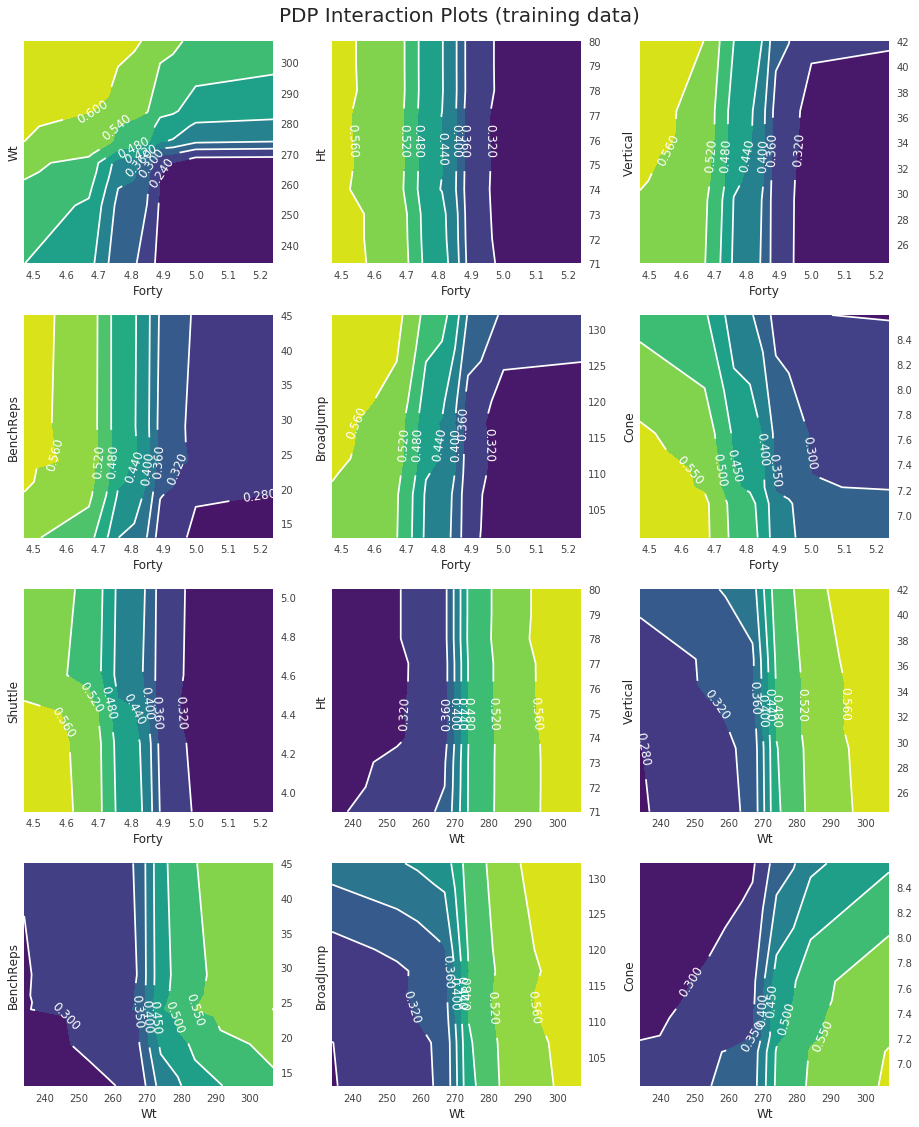

In [63]:
# and now plot a grid of PDP interaction plots
# NOTE that the contour colors do not represent the same values
# across the different subplots
fig = plot_2d_pdp_grid(train_feat_inters, forty_wt_feat_pairs)
fig.tight_layout()
fig.suptitle('PDP Interaction Plots (training data)', fontsize=20)
fig.subplots_adjust(top=0.95);

# LIME

Local interpretable model-agnostic explanations (LIME) allow us to explain individual predictions for "black box" models by creating local, interpretable, surrogate models. We fit a local model using the following recipe (which I copied from [Christop Molnar's](https://twitter.com/ChristophMolnar) great book, [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/lime.html)):

> 
- Choose your instance of interest for which you want to have an explanation of its black box prediction.
- Perturb your dataset and get the black box predictions for these new points.
- Weight the new samples by their proximity to the instance of interest.
- Fit a weighted, interpretable model on the dataset with the variations.
- Explain prediction by interpreting the local model.

There are different packages that implement LIME (including `eli5` and another package I just discovered called `Skater`). Here we will use the original `lime` package created by the authors of the LIME [paper](https://arxiv.org/abs/1602.04938).

In [64]:
import lime
from lime.lime_tabular import LimeTabularExplainer

Let's create our LIME explainer and explain an instance from our test set.

In [65]:
# create the explainer by passing our training data, 
# setting the correct modeling mode, pass in feature names and
# make sure we don't discretize the continuous features
explainer = LimeTabularExplainer(train_X_imp_df, mode='regression', 
                                 feature_names=features, 
                                 random_state=RANDOM_STATE, 
                                 discretize_continuous=False) 

In [66]:
test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)
# the number of features to include in our predictions
num_features = len(features)
# the index of the instance we want to explaine
exp_idx = 2
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 estimator.predict, num_features=num_features)

Cool, now we have our explanation, let's inspect it.

In [67]:
# the prediction made by the local surrogate model
exp.local_pred[0]

0.40375409629113346

In [68]:
# the bias term for the local explanation
exp.intercept[0]

0.4044365285762989

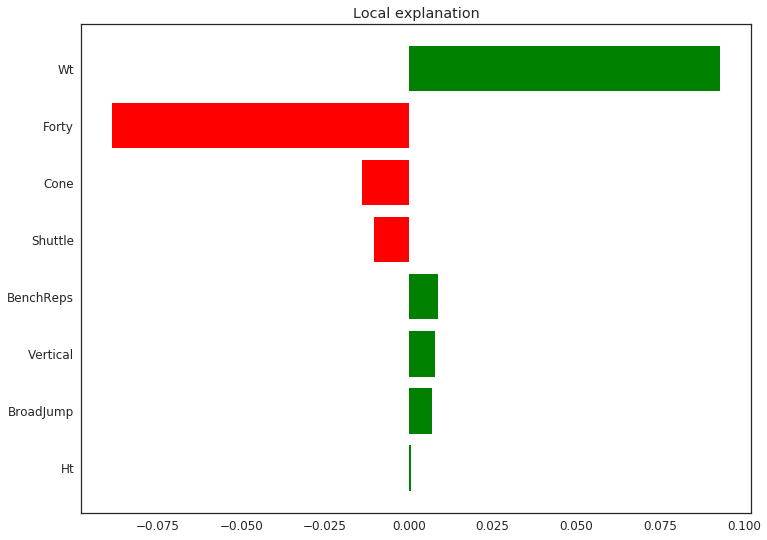

In [69]:
# a plot of the weights for each feature
exp.as_pyplot_figure();

In [70]:
# # and a prettier output that we can view in the notebook
# # it looks like it messes with the blog post so I've commented it out
# exp.show_in_notebook()

Great, we have an explanation for that one instance, what about the rest of the test set? We can use the `apply` method to get explanation for the whole test set.

**NOTE:** We can't parallelize `explain_instance` with the multiprocessing function since `explain_instance` is a bound method.

In [71]:
lime_expl = test_X_imp_df.apply(explainer.explain_instance, 
                                predict_fn=estimator.predict, 
                                num_features=num_features,
                                axis=1)

Before moving on we should double check and see that the local predictions from our surrogate models match our actual predictions. We can judge the local prediction by looking at either the root-mean-squared error or the R<sup>2</sup>

In [72]:
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
# get all the lime predictions
lime_pred = lime_expl.apply(lambda x: x.local_pred[0])
# RMSE of lime pred
mean_squared_error(y_pred, lime_pred)**0.5

0.0539942387861127

In [74]:
# r^2 of lime predictions
r2_score(y_pred, lime_pred)

0.8255823734122261

If you aren't satisfied with the fit of the local surrogate models you can try to improve them by playing around with the `kernel_width` parameter in `LimeTabularExplainer`. We will try and improve the surrogate models by decreasing the kernel width to make the fits more local.

In [75]:
# new explainer with smaller kernel_width
better_explainer = LimeTabularExplainer(train_X_imp_df, mode='regression', 
                                        feature_names=features, 
                                        random_state=RANDOM_STATE, 
                                        discretize_continuous=False,
                                        kernel_width=1) 

In [76]:
better_lime_expl = test_X_imp_df.apply(better_explainer.explain_instance, 
                                       predict_fn=estimator.predict, 
                                       num_features=num_features,
                                       axis=1)

In [77]:
# get all the lime predictions
better_lime_pred = better_lime_expl.apply(lambda x: x.local_pred[0])
# RMSE of lime pred
mean_squared_error(y_pred, better_lime_pred)**0.5

0.036564786949891966

In [78]:
# r^2 of lime predictions
r2_score(y_pred, better_lime_pred)

0.9200125924240036

Our new local predictions better match our actual predictions. To view all of our explanations at once we can create heatmap in the same manner we did when looking at the feature contributions. To do that we need to create a `DataFrame` with each instance's feature weights and bias term from the LIME explanation.

In [79]:
# construct a DataFrame with all the feature weights and bias terms from LIME
# create an individual dataframe for each explanation
lime_dfs = [pd.DataFrame(dict(expl.as_list() + [('bias', expl.intercept[0])]), index=[0]) 
            for expl in better_lime_expl]
# then concatenate them into one big DataFrame
lime_expl_df = pd.concat(lime_dfs, ignore_index=True)

lime_expl_df.head()

,BenchReps,BroadJump,Cone,Forty,Ht,Shuttle,Vertical,Wt,bias
0,0.010832,0.005010,-0.013976,-0.101409,0.000328,-0.010943,0.006622,0.113631,0.398066
1,0.010999,0.001341,-0.006558,-0.091564,0.004097,-0.006873,0.008604,0.091956,0.417362
2,0.006134,0.006262,-0.014019,-0.105977,-0.001826,-0.013650,0.008932,0.097897,0.398528
3,0.011381,0.016120,-0.016109,-0.109383,-0.001645,-0.012768,0.011177,0.076516,0.387108
4,0.008386,0.002198,-0.012827,-0.052986,0.002043,0.002295,0.003531,0.092838,0.418127


Now that we have the weights for each feature we can measure their prediction contributions by multiplying the weights by the actual feature values. But before we do that we need to scale the data in our test set since LIME scales the data inside the explainer when the data is not discretized.

In [80]:
# scale the data
scaled_X = (test_X_imp_df - explainer.scaler.mean_) / explainer.scaler.scale_
# calc the lime feature contributions
lime_feat_contrib = lime_expl_df[features] * scaled_X

# add on bias term, actual av %ile and predicted %ile
other_lime_cols = ['bias', 'true_AV_pctile', 'pred_AV_pctile']
lime_feat_contrib[other_lime_cols] = pd.DataFrame(np.column_stack((lime_expl_df.bias,
                                                                   y_test_and_pred_df)))

lime_feat_contrib.sort_values('pred_AV_pctile', inplace=True)

lime_feat_contrib.head()

,Forty,Wt,Ht,Vertical,BenchReps,BroadJump,Cone,Shuttle,bias,true_AV_pctile,pred_AV_pctile
33,-0.100389,-0.082229,0.000335,-0.000075,-0.008814,0.000285,0.000167,0.000342,0.340199,0.002427,0.169148
66,-0.030345,-0.044242,-0.007281,-0.029035,-0.023027,0.000036,-0.037809,-0.014340,0.384037,0.002427,0.178106
62,-0.074079,-0.066658,0.000388,-0.006869,-0.021616,-0.009128,0.000177,0.000684,0.385597,0.002427,0.178733
12,-0.085866,-0.035871,-0.000092,-0.005335,-0.011414,0.000289,0.000165,0.004688,0.394979,0.002427,0.179089
78,-0.087621,-0.090172,-0.000165,-0.000076,-0.002924,0.000320,0.000216,0.000499,0.379018,0.415049,0.180330


Now to plot each set of explanations using our `double_heatmap` function. Unlike previous heatmaps, we will include the bias terms since the surrogate models that LIME creates can have different bias terms for each player.

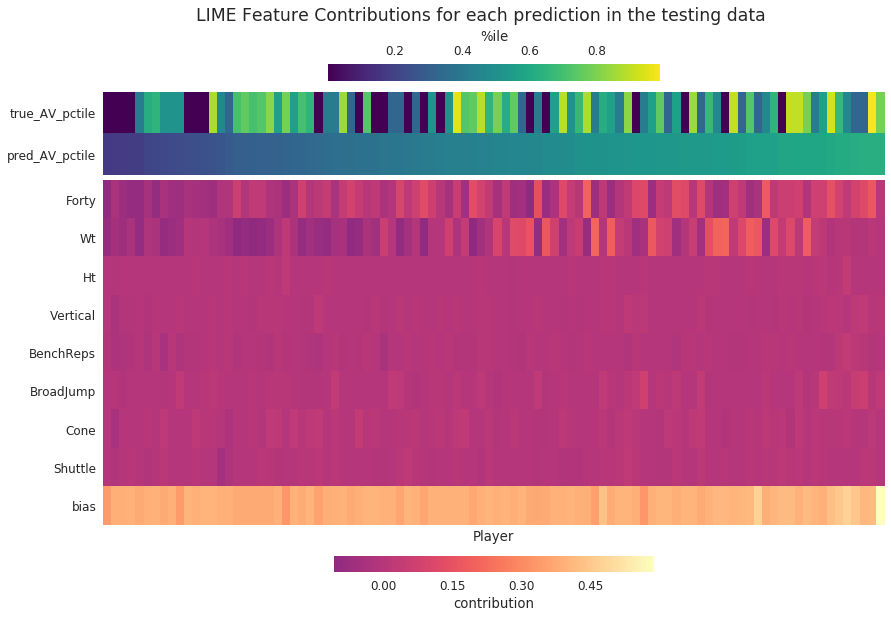

In [81]:
title = 'LIME Feature Contributions for each prediction in the testing data'
fig = double_heatmap(lime_feat_contrib[['true_AV_pctile', 'pred_AV_pctile']].T,
                     lime_feat_contrib.loc[:, :'bias'].T, title=title,
                     cbar_label1='%ile', cbar_label2='contribution', 
                     subplot_top=0.9)
# set the x-axis label for the bottom heatmap
# fig has 4 axes object, the first 2 are the heatmaps, the other 2 are the colorbars
fig.axes[1].set_xlabel('Player');

# SHAP

SHAP (SHapley Additive exPlanations) is a recent method for model interpretation that leverages game theory to help measure the impact of the features on the predictions. What’s the benefit of using the SHAP method for individual feature contributions over the decision path method from before? Well with the decision path method we have to traverse down the decision tree crediting each feature for the difference in the predictions. This can result in individual contributions that favor features found in splits lower in the tree. The SHAP method doesn't have that problem as it doesn't rely on the order of the features specified by the tree, instead it calculates the contributions by basically averaging the differences in predictions over every possible feature ordering.  For more on this topic I suggest reading Scott Lindburg’s (one of the authors of the SHAP paper) [blog post](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27).  And for a good explanation of how SHAP values are calculated I suggest reading the [chapter on SHAP](https://christophm.github.io/interpretable-ml-book/shapley.html#) from Christopher Molnar's book.


Now let's actually use the SHAP method to explain our predictions.

In [148]:
import shap

# create our SHAP explainer
# shap_explainer = shap.TreeExplainer(estimator)
# # calculate the shapley values for our test set
# test_shap_vals = shap_explainer.shap_values(test_X_imp)

ImportError: cannot import name '_validate_lengths' from 'numpy.lib.arraypad' (/anaconda3/lib/python3.7/site-packages/numpy/lib/arraypad.py)

The `shap` package provides us with convenience functions to help us plot the SHAP values for our predictions. We can use `force_plot` to inspect individual predictions.

In [83]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

In [84]:
# plot the explanation for a single prediction
shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])

In the above explanation we can see that there is a base value (i.e. a bias term) of 0.4219, and that each feature pushes (i.e. adds to) that value in order to reach a final prediction of 0.46.
  

We can also use the `force_plot` function to look at the explanations for our whole dataset. When using the function in a notebook, it produces an interactive plot that allows you to inspect the SHAP values for each observation by hovering the mouse over the plot. By default the observations are clustered together by how similar they are. For example, the first 17 observations in the plot below are players whose weights have a very large positive impact on their predictions. 

In [85]:
shap.force_plot(test_shap_vals, test_X_imp_df)

To plot the distribution of each feature's SHAP we can use the `summary_plot` function.

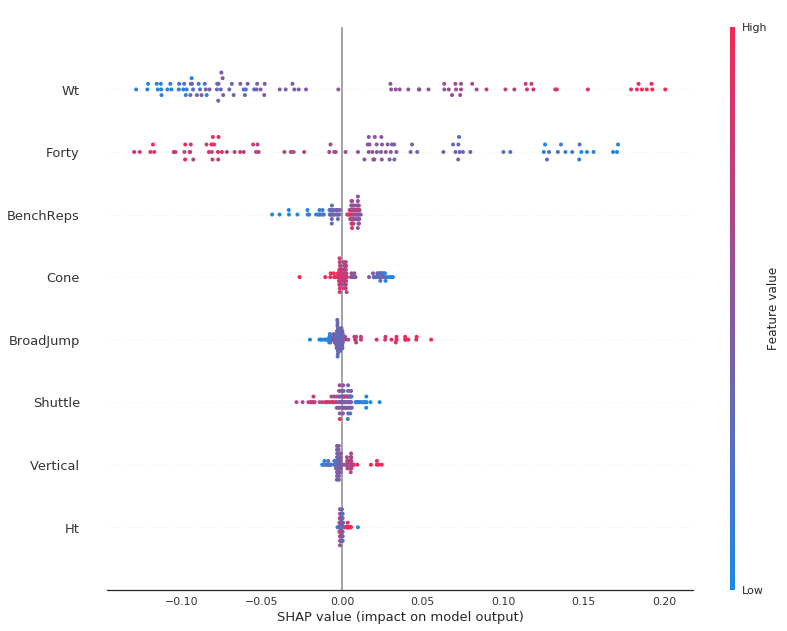

In [86]:
shap.summary_plot(test_shap_vals, test_X_imp_df, auto_size_plot=False)

With the `dependence_plot` function we can see how a feature's SHAP values change over the range of feature values. The function automatically colors each point on the plot by a 2nd feature, allowing us to better understand the interaction effects. 

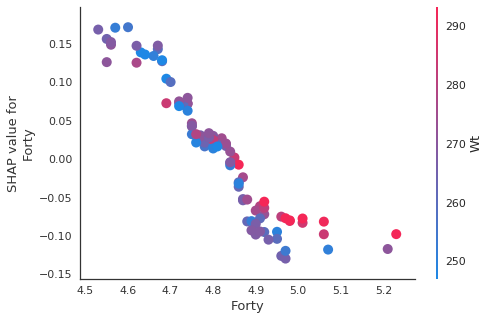

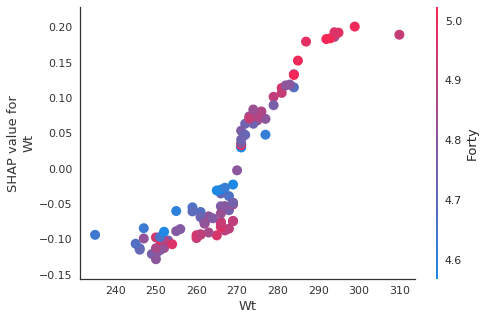

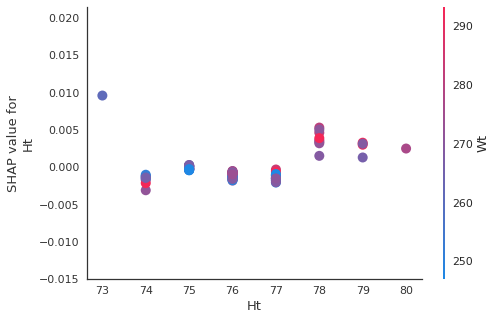

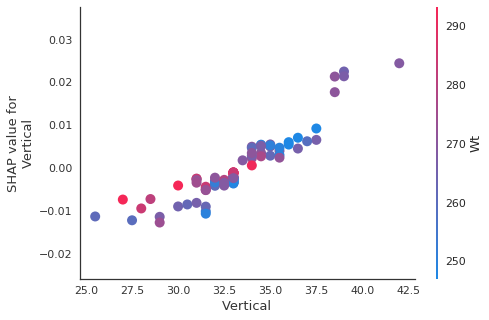

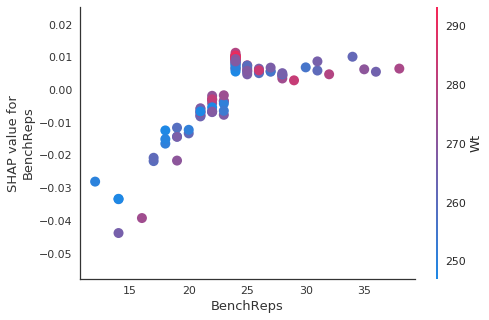

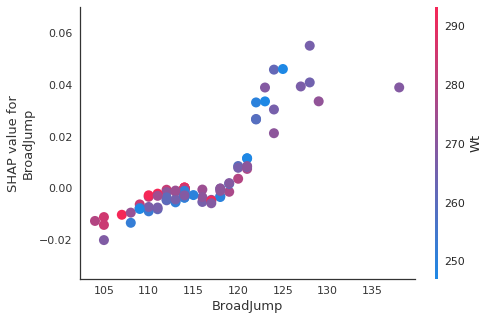

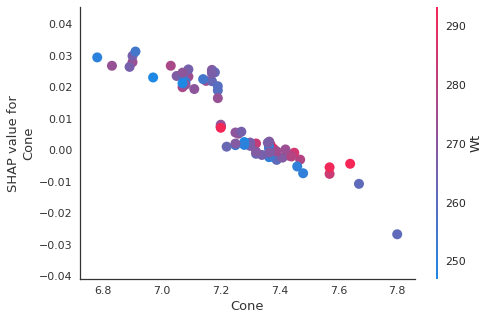

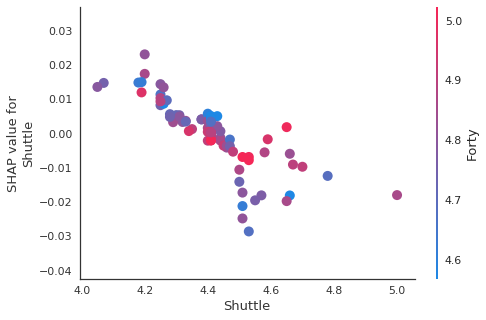

In [87]:
for feat in features:
    shap.dependence_plot(feat, test_shap_vals, test_X_imp_df, 
                         dot_size=100)

And of course a heatmap of the SHAP values.

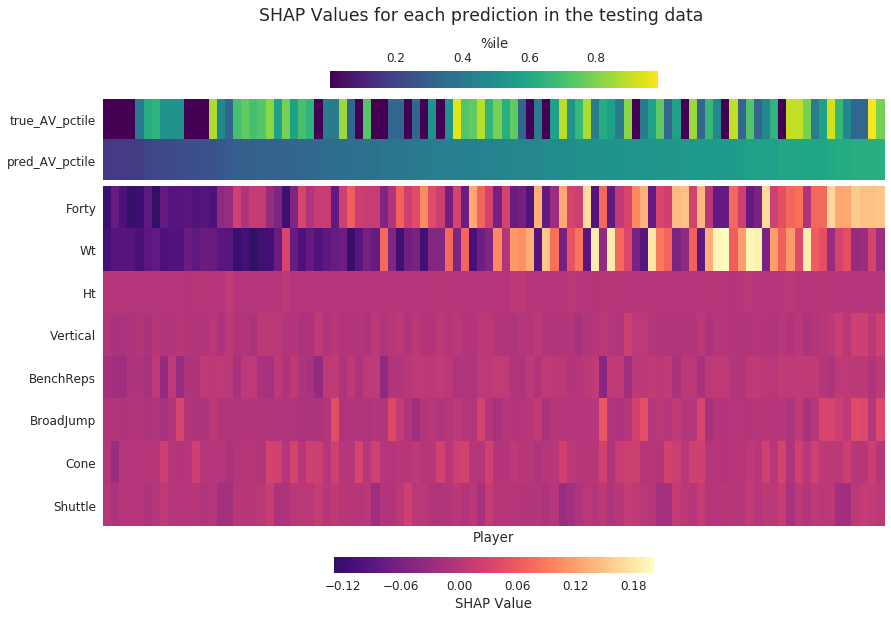

In [88]:
test_shap_df = pd.DataFrame(np.column_stack((test_shap_vals, y_test_and_pred_df)),
                            columns= features + ['bias', 'true_AV_pctile', 
                                                 'pred_AV_pctile'])
test_shap_df.sort_values('pred_AV_pctile', inplace=True)

title = 'SHAP Values for each prediction in the testing data'
fig = double_heatmap(test_shap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
                     test_shap_df[features].T, '%ile', 'SHAP Value',
                     title=title, subplot_top=0.89)
fig.axes[1].set_xlabel('Player');

Hopefully you found this blog post helpful.  If you see any mistakes, have any questions or suggestions  [or if you're hiring :)] you can email me at savvas.tjortjoglou@gmail.com, hit me up on Twitter [@savvastj](https://twitter.com/savvastj), or just leave a comment below.

If you like this post and want to support my blog you can check out my patreon page [here](https://www.patreon.com/savvastj).

# Resources

Here are a list of resources that I found helpful when writing up this post:

**General**
- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)

**Feature Importance**
- [How are feature_importances in RandomForestClassifier determined?](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)
- [Selecting good features – Part III: random forests](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)

**Feature Contributions**
- [Interpreting random forests](http://blog.datadive.net/interpreting-random-forests/)
- [Random forest interpretation with scikit-learn](http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/)
- [Random forest interpretation – conditional feature contributions](http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/)

**ICE plots and PDPs**
- [Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation](https://arxiv.org/abs/1309.6392)

**LIME**
- ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938)
- [Why your relationship is likely to last (or not): using Local Interpretable Model-Agnostic Explanations (LIME)](http://blog.fastforwardlabs.com/2017/09/01/LIME-for-couples.html)
- [Understanding LIME](https://cran.r-project.org/web/packages/lime/vignettes/Understanding_lime.html)

**SHAP**
- [Interpretable Machine Learning with XGBoost](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)
- [Consistent Individualized Feature Attribution for Tree Ensembles](https://arxiv.org/abs/1802.03888)

**NFL Combine/Draft**
- The NFL Combine Actually Matters
    - [Part 1](http://harvardsportsanalysis.org/2015/02/the-nfl-combine-actually-matters/)
    - [Part 2](http://harvardsportsanalysis.org/2015/02/the-combine-actually-matters-part-2/)
    - [Part 3](http://harvardsportsanalysis.org/2015/02/the-combine-actually-matters-part-3-predicting-the-draft/)

    
**Videos**
- [Machine Learning and Interpretability](https://www.youtube.com/watch?v=NxYCY8-Qfx0)
- [Towards interpretable reliable models](https://www.youtube.com/watch?v=B3PtcF-6Dtc)
- [Interpretable Machine Learning Using LIME Framework](https://www.youtube.com/watch?v=CY3t11vuuOM)
- [Explaining behavior of Machine Learning models with eli5 library](https://www.youtube.com/watch?v=s-yT5Is1G1A)

**Model Interpretability Packages**
- [treeinterpreter](https://github.com/andosa/treeinterpreter)
- [eli5](https://github.com/TeamHG-Memex/eli5/tree/master/eli5)
- [pycebox](https://github.com/AustinRochford/PyCEbox)
- [pdpbox](https://github.com/SauceCat/PDPbox)
- [lime](https://github.com/marcotcr/lime)
- [shap](https://github.com/slundberg/shap)
- [Skater](https://github.com/datascienceinc/Skater)
    
As always you can find the notebook and data used for this post on [github](https://github.com/savvastj/model_interpretability_post).